In [25]:
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [26]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [31]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [32]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [34]:
batch_size=100
train_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)

In [35]:
VGG1_channels = [
    64, 64, 'Max', 128, 128, 'Max', 256, 256, 'Max'
]

import torch.nn as nn

class VGG(torch.nn.Module):
    def __init__(self, VGG_channels, activation, in_channels=3):
        super().__init__()
        self.activation = activation
        self.in_channels = in_channels
        self.layers = []
        self.convolution_layers = self.create_convolution_layers(VGG_channels)
        self.fcs = nn.Sequential(
                nn.Linear(4096, 10)
                )
        
        
    def forward(self, x):
        x = self.convolution_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_convolution_layers(self, VGG_channels):

        for channels in VGG_channels:
            if channels == 'Max':
                max_pool_layer = [nn.MaxPool2d(kernel_size=(2,2))]
                self.layers += max_pool_layer
            else:
                conv_layer = [nn.Conv2d(in_channels=self.in_channels, out_channels=channels,
                                                 kernel_size=(3,3), padding='same'), self.activation()]
                self.layers += conv_layer
                self.in_channels = channels

        return nn.Sequential(*self.layers)   
    

In [36]:
%%timeit -n1 -r1
model = VGG(VGG1_channels, nn.SELU)
num_epochs = 5
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    print('epoch: ', (epoch+1))
    correct, total = 0, 0
    running_loss = 0
    for images, labels in train_loader:
        y_hat = model(images)
        loss = cost(y_hat, labels)
        running_loss += loss.item()
        y_pred = torch.softmax(y_hat, dim=1)
        pred = y_pred.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += int(labels.shape[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    epoch_loss = running_loss/total
    epoch_acc = correct/total
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_acc)
    print(f'Epoch Loss: {epoch_loss}')
    print(f'Epoch Correct: {correct}')
    print(f'Epoch Accuracy: {epoch_acc}')
    
    val_correct, val_total = 0, 0
    running_val_loss = 0
    for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs)
        val_loss = cost(val_outputs, val_labels)
        running_val_loss += val_loss.item()
        y_pred = torch.softmax(val_outputs, dim=1)
        pred = y_pred.max(1, keepdim=True)[1]
        val_correct += pred.eq(val_labels.view_as(pred)).sum().item()
        val_total += int(val_labels.shape[0])
    
    
    val_epoch_loss = running_val_loss/val_total
    val_epoch_acc = val_correct/val_total
    val_loss_history.append(val_epoch_loss)
    val_accuracy_history.append(val_epoch_acc)
    print(f'Epoch Validation Loss: {val_epoch_loss}')
    print(f'Epoch Validation Correct: {val_correct}')
    print(f'Epoch Validation Accuracy: {val_epoch_acc}')
    

epoch:  1
Epoch Loss: 0.019726427903175355
Epoch Correct: 14369
Epoch Accuracy: 0.28738
Epoch Validation Loss: 0.008587508130073548
Epoch Validation Correct: 1939
Epoch Validation Accuracy: 0.3878
epoch:  2
Epoch Loss: 0.015825673410892485
Epoch Correct: 21798
Epoch Accuracy: 0.43596
Epoch Validation Loss: 0.007437928009033203
Epoch Validation Correct: 2374
Epoch Validation Accuracy: 0.4748
epoch:  3
Epoch Loss: 0.014078107316493988
Epoch Correct: 25032
Epoch Accuracy: 0.50064
Epoch Validation Loss: 0.006770377540588379
Epoch Validation Correct: 2573
Epoch Validation Accuracy: 0.5146
epoch:  4
Epoch Loss: 0.012729572259187699
Epoch Correct: 27454
Epoch Accuracy: 0.54908
Epoch Validation Loss: 0.00610273118019104
Epoch Validation Correct: 2849
Epoch Validation Accuracy: 0.5698
epoch:  5
Epoch Loss: 0.01157700992822647
Epoch Correct: 29624
Epoch Accuracy: 0.59248
Epoch Validation Loss: 0.005603573536872864
Epoch Validation Correct: 3017
Epoch Validation Accuracy: 0.6034
27min 50s ± 0 ns 

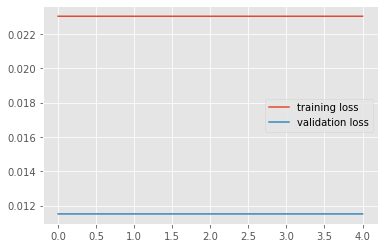

In [37]:
plt.style.use('ggplot')
plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()

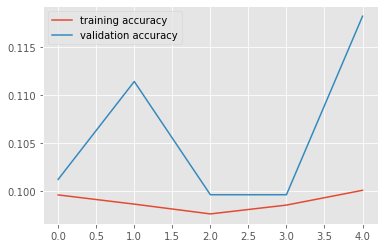

In [38]:
plt.style.use('ggplot')
plt.plot(train_accuracy_history, label='training accuracy')
plt.plot(val_accuracy_history, label='validation accuracy')
plt.legend()

In [39]:
test_correct, test_total = 0, 0
for test_inputs, test_labels in test_loader:
    test_outputs = model(test_inputs)
    y_pred = torch.softmax(test_outputs, dim=1)
    pred = y_pred.max(1, keepdim=True)[1]
    test_correct += pred.eq(test_labels.view_as(pred)).sum().item()
    test_total += int(test_labels.shape[0])

test_acc = test_correct/test_total
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.115


In [47]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1186378

In [40]:
%%timeit -n1 -r1
model = VGG(VGG1_channels, nn.SiLU)
num_epochs = 5
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    print('epoch: ', (epoch+1))
    correct, total = 0, 0
    running_loss = 0
    for images, labels in train_loader:
        y_hat = model(images)
        loss = cost(y_hat, labels)
        running_loss += loss.item()
        y_pred = torch.softmax(y_hat, dim=1)
        pred = y_pred.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += int(labels.shape[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    epoch_loss = running_loss/total
    epoch_acc = correct/total
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_acc)
    print(f'Epoch Loss: {epoch_loss}')
    print(f'Epoch Correct: {correct}')
    print(f'Epoch Accuracy: {epoch_acc}')
    
    val_correct, val_total = 0, 0
    running_val_loss = 0
    for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs)
        val_loss = cost(val_outputs, val_labels)
        running_val_loss += val_loss.item()
        y_pred = torch.softmax(val_outputs, dim=1)
        pred = y_pred.max(1, keepdim=True)[1]
        val_correct += pred.eq(val_labels.view_as(pred)).sum().item()
        val_total += int(val_labels.shape[0])
    
    
    val_epoch_loss = running_val_loss/val_total
    val_epoch_acc = val_correct/val_total
    val_loss_history.append(val_epoch_loss)
    val_accuracy_history.append(val_epoch_acc)
    print(f'Epoch Validation Loss: {val_epoch_loss}')
    print(f'Epoch Validation Correct: {val_correct}')
    print(f'Epoch Validation Accuracy: {val_epoch_acc}')

epoch:  1
Epoch Loss: 0.023026581926345824
Epoch Correct: 4979
Epoch Accuracy: 0.09958
Epoch Validation Loss: 0.011512902975082397
Epoch Validation Correct: 472
Epoch Validation Accuracy: 0.0944
epoch:  2
Epoch Loss: 0.023026293845176696
Epoch Correct: 4902
Epoch Accuracy: 0.09804
Epoch Validation Loss: 0.01151277937889099
Epoch Validation Correct: 472
Epoch Validation Accuracy: 0.0944
epoch:  3
Epoch Loss: 0.023026107172966003
Epoch Correct: 4998
Epoch Accuracy: 0.09996
Epoch Validation Loss: 0.011512915182113647
Epoch Validation Correct: 472
Epoch Validation Accuracy: 0.0944
epoch:  4
Epoch Loss: 0.023026015248298646
Epoch Correct: 4953
Epoch Accuracy: 0.09906
Epoch Validation Loss: 0.011512883234024048
Epoch Validation Correct: 472
Epoch Validation Accuracy: 0.0944
epoch:  5
Epoch Loss: 0.023025930323600768
Epoch Correct: 4990
Epoch Accuracy: 0.0998
Epoch Validation Loss: 0.01151270546913147
Epoch Validation Correct: 480
Epoch Validation Accuracy: 0.096
26min 23s ± 0 ns per loop (me

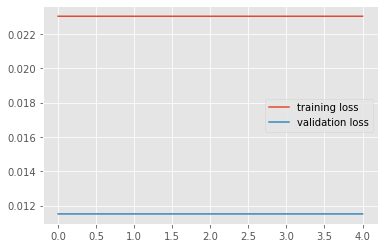

In [41]:
plt.style.use('ggplot')
plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()

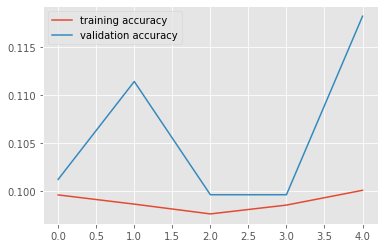

In [42]:
plt.style.use('ggplot')
plt.plot(train_accuracy_history, label='training accuracy')
plt.plot(val_accuracy_history, label='validation accuracy')
plt.legend()

In [43]:
test_correct, test_total = 0, 0
for test_inputs, test_labels in test_loader:
    test_outputs = model(test_inputs)
    y_pred = torch.softmax(test_outputs, dim=1)
    pred = y_pred.max(1, keepdim=True)[1]
    test_correct += pred.eq(test_labels.view_as(pred)).sum().item()
    test_total += int(test_labels.shape[0])

test_acc = test_correct/test_total
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.115


In [46]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1186378